In [1]:
cd ..

c:\Users\seand\OneDrive\Dokumente\Masterthesis\StarBoundaryNetworks\src


In [2]:
import torch
from torch.autograd.functional import hessian
from torch import nn
from tqdm import tqdm

from domains.starDomain import Sphere
from radialFunctions.radialFunctions import linearRadial
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib as mpl
from scipy.interpolate import griddata
from ipywidgets import *
import numpy as np
#%matplotlib notebook
%matplotlib widget

# Define Problem

$u_xx(x,y) + u_yy(x,y) = sin(xy)$ on unit sphere

and boundary condition $u(x,y) = x+y$ on boundary of sphere

## Define Loss funciton

In [3]:
def laplacian(f, input):
    dim = input.shape[1]
    batchSize = input.shape[0]
    outf = f(input)
    laplacian = torch.zeros(batchSize, dtype=float, requires_grad=True)


    

    dx = torch.autograd.grad(outf, input, torch.ones((batchSize, 1), requires_grad=True), create_graph=True)[0]

    for i in range(dim):
        d2x = torch.autograd.grad((dx[:,i]).view(-1,1), input, torch.ones((batchSize, 1), requires_grad=True), create_graph=True)[0][:,i]
        laplacian = laplacian + d2x



    return laplacian.view(-1,1)
    


In [4]:
#define PINN loss function for problem from above:
def pinnLossPoissonSin(u, xy_grid):
  laplacian_u = laplacian(u, xy_grid)
  #ignore non differentiable points
  maskWhereNotNan = laplacian_u.view(-1).isnan() == False
  laplacian_u_cleaned = laplacian_u[maskWhereNotNan]

  return torch.mean( torch.abs(laplacian_u_cleaned - torch.sin(xy_grid[maskWhereNotNan,0] * xy_grid[maskWhereNotNan, 1]).view(-1,1)  )  ), laplacian_u


In [5]:
#define PINN loss function for problem from above with boundary condition:
def pinnLossPoissonSinWithBoundary(u, xy_grid, boundaryGrid, alpha = 1, beta = 0.1):#, device = 'cuda'):
    laplacian_u = laplacian(u, xy_grid)
    #ignore non differentiable points
    maskWhereNotNan = laplacian_u.view(-1).isnan() == False
    laplacian_u_cleaned = laplacian_u[maskWhereNotNan]

    uOnBoundary = u(boundaryGrid)

    expectedBoundaryValue = (boundaryGrid[:,0] + boundaryGrid[:,1]).view(-1,1)

    return alpha * torch.mean( torch.abs(laplacian_u_cleaned - torch.sin(xy_grid[maskWhereNotNan,0] * xy_grid[maskWhereNotNan, 1]).view(-1,1)  )  ) + beta * torch.mean(torch.abs(uOnBoundary - expectedBoundaryValue )), laplacian_u


In [6]:
#Example on how to use laplacian
grid = torch.arange(10, dtype=float, requires_grad=True).view(-1,2)
def f(grid):
    x1 = grid[:, 0]
    x2 = grid[:, 1]
    return (x1*x1*x2*x2).view(-1,1)

laplacian(f, grid)

tensor([[  2.],
        [ 26.],
        [ 82.],
        [170.],
        [290.]], dtype=torch.float64, grad_fn=<ViewBackward0>)

# Define Neural Network without imposed BC

In [7]:
class PINNModel(nn.Module):
  def __init__(self, n_hidden, n_layers):
    super().__init__()
    self.activation_func = nn.Tanh
    self.in_layer = nn.Sequential(*[nn.Linear(2,n_hidden) , self.activation_func()])
    self.hid_layers = nn.Sequential(*[
        nn.Sequential(*[
            nn.Linear(n_hidden, n_hidden),
            nn.Tanh()
            ])
        for i in range(n_layers)], nn.Linear(n_hidden, n_hidden))
    self.out_layer = nn.Linear(n_hidden,1)

 
  
  def forward(self, input):
    x = input + 0
   
    x = self.in_layer(x)
   
    x = self.hid_layers(x)
   
    x = self.out_layer(x)
   

    return x

# Define Neural Network with imposed BC

In [20]:
class ImposedBCPINNSphere2D(nn.Module):
  def __init__(self, n_hidden, n_layers):
    super().__init__()
    self.activation_func = nn.Tanh
    self.in_layer = nn.Sequential(*[nn.Linear(2,n_hidden) , self.activation_func()])
    self.hid_layers = nn.Sequential(*[
        nn.Sequential(*[
            nn.Linear(n_hidden, n_hidden),
            nn.Tanh()
            ])
        for i in range(n_layers)], nn.Linear(n_hidden, n_hidden))
    self.out_layer = nn.Linear(n_hidden,1)
    self.domain = Sphere(2, torch.tensor((0.,0.)), torch.tensor(1.))
    self.radialDecayFunciton = linearRadial
  

  def boundaryCondition(self, input):
    return input[:,0] + input[:,1]
  
  def boundaryConditionSpherical(self, angles):
    return self.boundaryCondition(self.domain.getCartesianCoordinates( self.domain.radiusDomainFunciton(angles) ,angles))
  
  def zeroOnBoundaryExtension(self, input):
    radius, angles = self.domain.getSphericalCoordinates(input)
    return self.radialDecayFunciton( radius / self.domain.radiusDomainFunciton(angles)).view(-1,1)
  
  def DCBoundaryExtension(self, input):
    radius, angles = self.domain.getSphericalCoordinates(input)
    return (self.boundaryConditionSpherical( angles) *  (1- self.radialDecayFunciton( radius / self.domain.radiusDomainFunciton(angles)))).view(-1,1)
  
  def forward(self, input):
    x = input + 0
   
    x = self.in_layer(x)
   
    x = self.hid_layers(x)
   
    x = self.out_layer(x)
   

    return x*self.zeroOnBoundaryExtension(input) + self.DCBoundaryExtension(input)

# Generate Training Data

In [9]:
#generate Points for training
sphereForPoints  = Sphere(2,torch.tensor([0.0,0.0]), torch.tensor(1.))
spherePoints = sphereForPoints.generateCartesianRandomPointsFullDomain(100000)


In [10]:
pointsOnBoundary = sphereForPoints.generateSphericalRandomPointsOnBoundary(1000)

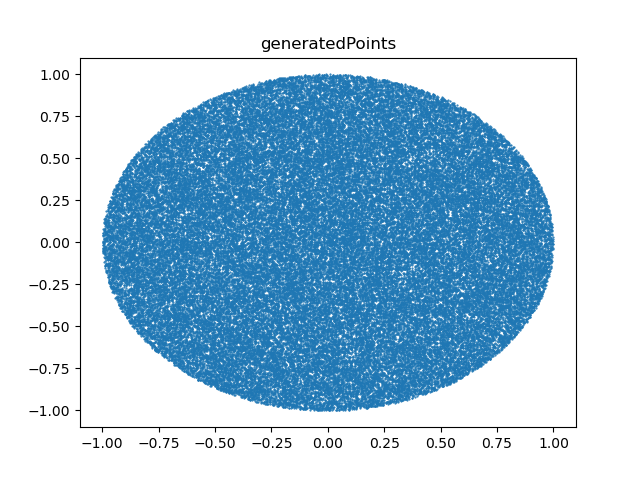

In [11]:
#plot generated points
fig1 = plt.figure()
ax1 = fig1.add_subplot(1,1,1)
ax1.set_title('generatedPoints')
ax1.scatter(spherePoints[:,0],spherePoints[:,1],s = 0.3)
plt.show()

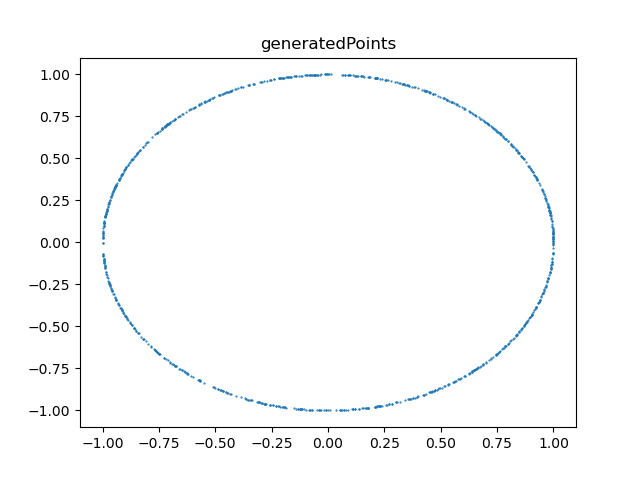

In [12]:
#plot generated points
fig1b = plt.figure()
ax1b = fig1b.add_subplot(1,1,1)
ax1b.set_title('generatedPoints')
ax1b.scatter(pointsOnBoundary[:,0],pointsOnBoundary[:,1],s = 0.3)
plt.show()

# Train NN with imposed BC

In [43]:
#define Trainingset, epochs, lr:
xy_grid = spherePoints
xy_grid.requires_grad = True
epochs = 100
learningRate  = 1e-3

In [44]:
#define model:
solPDE = ImposedBCPINNSphere2D( 15, 5)

In [45]:
#define optimizer
optimizer = torch.optim.Adam(solPDE.parameters(), lr = learningRate)

In [46]:
#computes initial loss to see where we start
loss, points = pinnLossPoissonSin(solPDE, xy_grid )
loss

tensor(0.2525, dtype=torch.float64, grad_fn=<MeanBackward0>)

In [ ]:
#training
for i in range(epochs):
  optimizer.zero_grad()
 
  loss,_ = pinnLossPoissonSin(solPDE, xy_grid )
  #if i%100 == 0:
  print(loss.item())
  loss.backward(retain_graph=True)
  optimizer.step()


0.25246779415250026
0.23482190823658494
0.2178693551964564
0.20177610128915963
0.1867935905435441
0.17332383017455305
0.16230579588368818
0.15967200403311588
0.16618942938339543
0.17165156859279196
0.17476275445420456
0.17551201967845914
0.1742757632705757
0.17154432105090794
0.16782648133994904
0.16363675856592066
0.15952431487317295
0.15633579667176067
0.15770540469287891


In [27]:
# Compute loss aftre training at single points
laplacian_u = laplacian(solPDE, xy_grid)
lossOnGrid = laplacian_u - torch.sin(xy_grid[:,0] * xy_grid[:, 1]).view(-1,1)

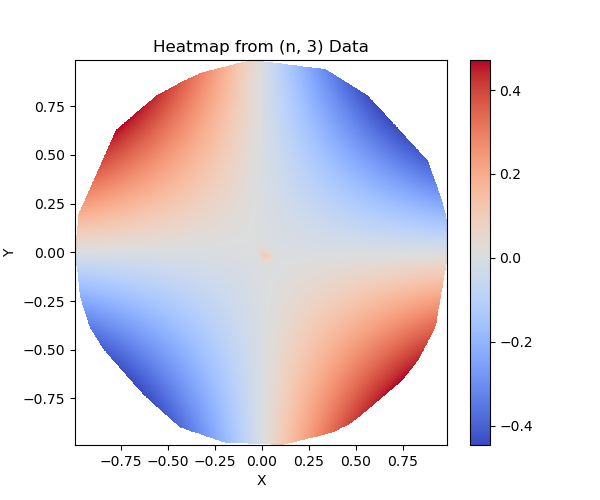

In [29]:
# Plot losses on training data points as heatmap

sampleSizeForDrawing = 1000
data = np.empty((sampleSizeForDrawing,3))
data[:,0] = xy_grid[:sampleSizeForDrawing,0].detach().numpy()
data[:,1] = xy_grid[:sampleSizeForDrawing,1].detach().numpy()
data[:,2] = lossOnGrid[:sampleSizeForDrawing].view(-1).detach().numpy()

# Create a meshgrid to interpolate over (choose grid resolution as needed)
grid_x, grid_y = np.mgrid[min(data[:, 0]):max(data[:, 0]):1000j, 
                          min(data[:, 1]):max(data[:, 1]):1000j]

# Interpolate the z values over the grid
grid_z = griddata((data[:, 0], data[:, 1]), data[:, 2], (grid_x, grid_y), method='cubic')



# Plot the heatmap
plt.figure(figsize=(6, 5))
plt.pcolormesh(grid_x, grid_y, grid_z, cmap='coolwarm', shading='auto')
plt.colorbar()  # Add colorbar to the side
plt.title("Heatmap from (n, 3) Data")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()


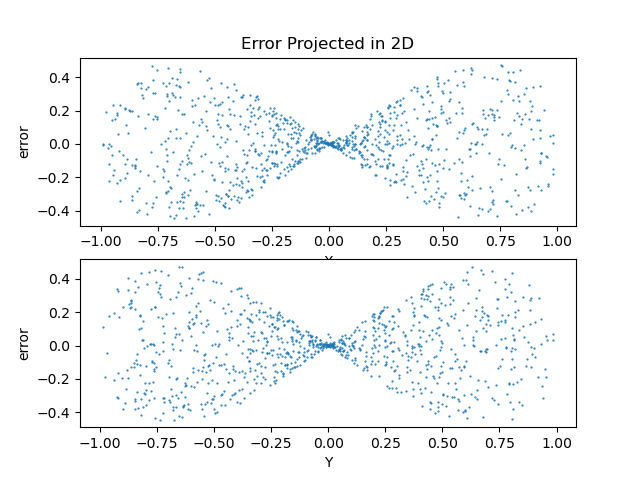

In [30]:
# Plot projected losses on xz and yz planes to see where "problems" happen

maxError = torch.inf
maskSmallerError = data[:,2]<maxError
fig5,ax5 = plt.subplots(2,1)#plt.figure()

ax5[0].set_title('Error Projected in 2D')
ax5[0].set_xlabel('X')
ax5[0].set_ylabel('error')


ax5[1].set_xlabel('Y')
ax5[1].set_ylabel('error')

ax5[0].scatter(data[maskSmallerError,0], data[maskSmallerError,2], s= 0.3)
ax5[1].scatter(data[maskSmallerError,1], data[maskSmallerError,2], s= 0.3)
plt.show()

C:\Users\seand\AppData\Local\Temp\ipykernel_8512\3043282009.py:19: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax6.scatter(x, y, z, cmap='viridis')


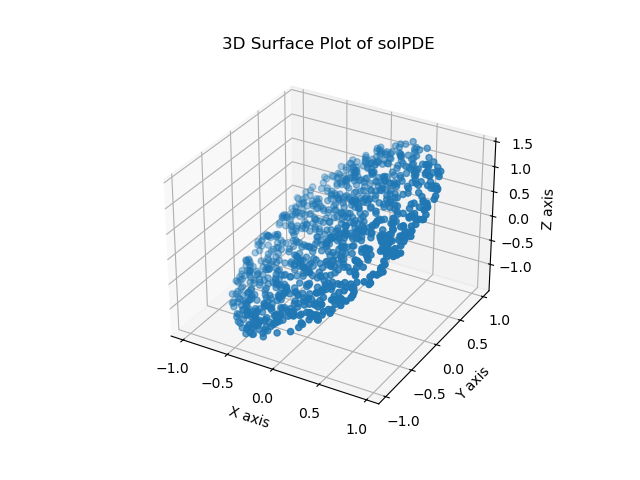

In [31]:

numPointsPlot = 1000
x = xy_grid[:numPointsPlot,0].view(-1).detach().numpy()
y = xy_grid[:numPointsPlot,1].view(-1).detach().numpy()
#X = x.tile((numPointsPlot,1)).detach().numpy()
#Y = y.view(-1,1).tile((1, numPointsPlot)).detach().numpy()
# Create a grid of x and y values
#x = np.linspace(0, 5, 5)
#y = np.linspace(0, 5, 5)
#X, Y = np.meshgrid(x, y)

# Compute Z values using the function f(x, y)
z = solPDE(xy_grid[:numPointsPlot]).view(-1).detach().numpy()

# Create a 3D plot
fig6 = plt.figure()
ax6 = fig6.add_subplot(111, projection='3d')

# Plot the surface
ax6.scatter(x, y, z, cmap='viridis')

# Add labels and title
ax6.set_xlabel('X axis')
ax6.set_ylabel('Y axis')
ax6.set_zlabel('Z axis')
ax6.set_title('3D Surface Plot of solPDE')

# Show plot
plt.show()


there seems to be a sharp corner at y = 0

# Train NN without imposed BC

In [32]:
#define Trainingset, epochs, lr:
xy_grid = spherePoints
xy_grid.requires_grad = True
boundaryGrid = pointsOnBoundary
epochs = 100
learningRate  = 1e-3

In [33]:
#define model:
regularPINN = PINNModel( 15, 5)

In [34]:
#define optimizer
optimizer = torch.optim.Adam(regularPINN.parameters(), lr = learningRate)

In [35]:
#computes initial loss to see where we start
loss, points = pinnLossPoissonSinWithBoundary(regularPINN, xy_grid, boundaryGrid )
loss

tensor(0.2452, dtype=torch.float64, grad_fn=<AddBackward0>)

In [36]:
#training
for i in range(epochs):
  optimizer.zero_grad()
 
  loss,_ = pinnLossPoissonSinWithBoundary(regularPINN, xy_grid , boundaryGrid, beta=1)
  #if i%100 == 0:
  print(loss.item())
  loss.backward(retain_graph=True)
  optimizer.step()


1.0435062974550737
1.042582625624314
1.042095126031814
1.0418418245210284
1.0417343157243382
1.041761122802231
1.0417634730089425
1.0417131829345485
1.0415024503300596
1.0410869280071449
1.0404331482096951
1.0394491872255103
1.0379792407250161
1.0356998994931652
1.0321623379057894
1.026730393097706
1.018529832432438
1.0064697355441479
0.9896010917894187
0.9688589040952362
0.9557165145243169
0.9581596199498775
0.9549665296295371
0.939916421805229
0.9332653235638236
0.9355506425055911
0.9330173744859478
0.9249410606800269
0.9123135825330699
0.9000408104144024
0.8950999232785967
0.8908006423924684
0.8819663092981167
0.8679548246377616
0.8510132887594092
0.8339375186237822
0.8183990241867709
0.8023618765877688
0.7810268416920103
0.7539051601946877
0.7247665421844152
0.694605159934561
0.6540876643648836
0.6183600952532684
0.5707467062268718
0.5167021596557617
0.4598734124301257
0.39991317351512135
0.409919009637234
0.9456935886506908
0.5517631545722919
0.5015014341459336
0.6790284594859612


In [37]:
# Compute loss aftre training at single points
laplacian_u = laplacian(regularPINN, xy_grid)
lossOnGrid = torch.abs(laplacian_u - torch.sin(xy_grid[:,0] * xy_grid[:, 1]).view(-1,1))

lossOnBoundary = torch.abs(regularPINN(boundaryGrid) - (boundaryGrid[:,0] + boundaryGrid[:,1]).view(-1,1))

totalGrid = torch.cat((xy_grid, boundaryGrid), 0)
allLoss = torch.cat((lossOnGrid, lossOnBoundary),0).view(-1)



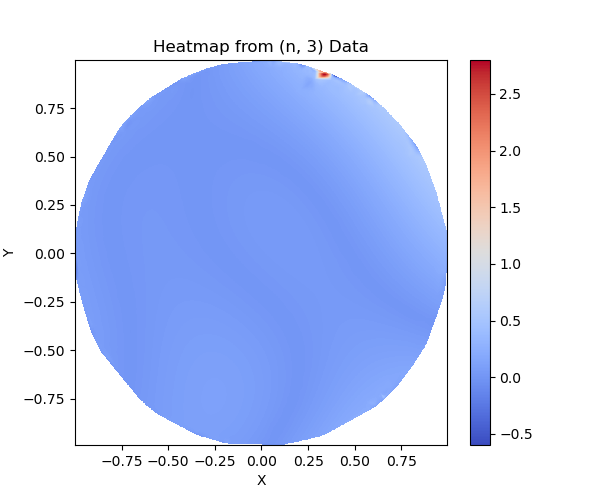

In [38]:
# Plot losses on training data points as heatmap

sampleSizeForDrawing = 3000
pickMask = torch.randint(0,allLoss.shape[0], (sampleSizeForDrawing,))
data = np.empty((sampleSizeForDrawing,3))
data[:,0] = totalGrid[pickMask,0].detach().numpy()
data[:,1] = totalGrid[pickMask,1].detach().numpy()
data[:,2] = allLoss[pickMask].view(-1).detach().numpy()

# Create a meshgrid to interpolate over (choose grid resolution as needed)
grid_x, grid_y = np.mgrid[min(data[:, 0]):max(data[:, 0]):1000j, 
                          min(data[:, 1]):max(data[:, 1]):1000j]

# Interpolate the z values over the grid
grid_z = griddata((data[:, 0], data[:, 1]), data[:, 2], (grid_x, grid_y), method='cubic')



# Plot the heatmap
plt.figure(figsize=(6, 5))
plt.pcolormesh(grid_x, grid_y, grid_z, cmap='coolwarm', shading='auto')
plt.colorbar()  # Add colorbar to the side
plt.title("Heatmap from (n, 3) Data")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()

C:\Users\seand\AppData\Local\Temp\ipykernel_8512\1868684707.py:20: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax6.scatter(x, y, z1, cmap='viridis',c = 'blue')
C:\Users\seand\AppData\Local\Temp\ipykernel_8512\1868684707.py:21: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax6.scatter(x, y, z2, cmap='viridis',c = 'red')


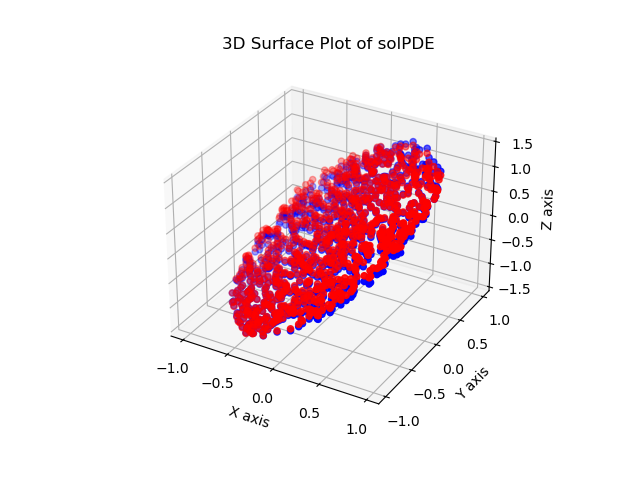

In [39]:
numPointsPlot = 1000
x = xy_grid[:numPointsPlot,0].view(-1).detach().numpy()
y = xy_grid[:numPointsPlot,1].view(-1).detach().numpy()
#X = x.tile((numPointsPlot,1)).detach().numpy()
#Y = y.view(-1,1).tile((1, numPointsPlot)).detach().numpy()
# Create a grid of x and y values
#x = np.linspace(0, 5, 5)
#y = np.linspace(0, 5, 5)
#X, Y = np.meshgrid(x, y)

# Compute Z values using the function f(x, y)
z1 = solPDE(xy_grid[:numPointsPlot]).view(-1).detach().numpy()
z2 = regularPINN(xy_grid[:numPointsPlot]).view(-1).detach().numpy()

# Create a 3D plot
fig6 = plt.figure()
ax6 = fig6.add_subplot(111, projection='3d')

# Plot the surface
ax6.scatter(x, y, z1, cmap='viridis',c = 'blue')
ax6.scatter(x, y, z2, cmap='viridis',c = 'red')

# Add labels and title
ax6.set_xlabel('X axis')
ax6.set_ylabel('Y axis')
ax6.set_zlabel('Z axis')
ax6.set_title('3D Surface Plot of solPDE')

# Show plot
plt.show( )
